# Amazon SageMaker Multi-Model Endpoints using your own algorithm container
With [Amazon SageMaker multi-model endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html), customers can create an endpoint that seamlessly hosts up to thousands of models. These endpoints are well suited to use cases where any one of a large number of models, which can be served from a common inference container, needs to be invokable on-demand and where it is acceptable for infrequently invoked models to incur some additional latency. For applications which require consistently low inference latency, a traditional endpoint is still the best choice.

At a high level, Amazon SageMaker manages the loading and unloading of models for a multi-model endpoint, as they are needed. When an invocation request is made for a particular model, Amazon SageMaker routes the request to an instance assigned to that model, downloads the model artifacts from S3 onto that instance, and initiates loading of the model into the memory of the container. As soon as the loading is complete, Amazon SageMaker performs the requested invocation and returns the result. If the model is already loaded in memory on the selected instance, the downloading and loading steps are skipped and the invocation is performed immediately.

For the inference container to serve multiple models in a multi-model endpoint, it must implement [additional APIs](https://docs.aws.amazon.com/sagemaker/latest/dg/build-multi-model-build-container.html) in order to load, list, get, unload and invoke specific models. This notebook demonstrates how to build your own inference container that implements these APIs.

---

### Contents

1. [Introduction to Multi Model Server (MMS)](#Introduction-to-Multi-Model-Server-(MMS))
  1. [Handling Out Of Memory conditions](#Handling-Out-Of-Memory-conditions)
  1. [SageMaker Inference Toolkit](#SageMaker-Inference-Toolkit)
1. [Building and registering a container using MMS](#Building-and-registering-a-container-using-MMS)
1. [Set up the environment](#Set-up-the-environment)
1. [Upload model artifacts to S3](#Upload-model-artifacts-to-S3)
1. [Create a multi-model endpoint](#Create-a-multi-model-endpoint)
  1. [Import models into hosting](#Import-models-into-hosting)
  1. [Create endpoint configuration](#Create-endpoint-configuration)
  1. [Create endpoint](#Create-endpoint)
1. [Invoke models](#Invoke-models)
  1. [Add models to the endpoint](#Add-models-to-the-endpoint)
  1. [Updating a model](#Updating-a-model)
1. [(Optional) Delete the hosting resources](#(Optional)-Delete-the-hosting-resources)

## Introduction to Multi Model Server (MMS)

[Multi Model Server](https://github.com/awslabs/multi-model-server) is an open source framework for serving machine learning models. It provides the HTTP frontend and model management capabilities required by multi-model endpoints to host multiple models within a single container, load models into and unload models out of the container dynamically, and performing inference on a specified loaded model.

MMS supports a pluggable custom backend handler where you can implement your own algorithm. This example uses a handler that supports loading and inference for MXNet models, which we will inspect below.

In [2]:
#!pygmentize container/model_handler.py

## Building and registering a container using MMS

The shell script below will build a Docker image which uses MMS as the front end (configured through SageMaker Inference Toolkit), and `container/model_handler.py` that we inspected above as the backend handler. It will then upload the image to an ECR repository in your account.

In [3]:
%%sh

# The name of our algorithm
algorithm_name=demo-sagemaker-multimodel

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -q -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
sha256:21b994c01753d97ff17f0eaf3aa749c91c605c6ffdd9e00955bfbd5b4a7aef1e
The push refers to repository [328296961357.dkr.ecr.us-east-2.amazonaws.com/demo-sagemaker-multimodel]
03724af0e984: Preparing
31a3d533fb8d: Preparing
f43d3f86257b: Preparing
e54bbb989677: Preparing
ec190f66ca99: Preparing
46a8573fc2cc: Preparing
9e7456ba3498: Preparing
6f92cdb490d9: Preparing
4ae3adcb66cb: Preparing
aa6685385151: Preparing
0040d8f00d7e: Preparing
9e6f810a2aab: Preparing
46a8573fc2cc: Waiting
9e7456ba3498: Waiting
6f92cdb490d9: Waiting
4ae3adcb66cb: Waiting
aa6685385151: Waiting
0040d8f00d7e: Waiting
9e6f810a2aab: Waiting
31a3d533fb8d: Pushed
03724af0e984: Pushed
e54bbb989677: Pushed
f43d3f86257b: Pushed
4ae3adcb66cb: Layer already exists
aa6685385151: Layer already exists
0040d8f00d7e: Layer already exists
9e6f810a2aab: Layer already exists
9e7456ba3498: Pushed
46a8573fc2cc: Pushed
ec190f66ca99: Pushed
6f92cdb490d9: Pushed
latest: digest: sha256:bf632e1fbbe0ec2ce46678eb1c909ba85872

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



## Set up the environment
Define the S3 bucket and prefix where the model artifacts that will be invokable by your multi-model endpoint will be located.

Also define the IAM role that will give SageMaker access to the model artifacts and ECR image that was created above.

In [4]:
!pip install -qU awscli boto3 sagemaker

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import boto3
from sagemaker import get_execution_role

sm_client = boto3.client(service_name='sagemaker')
runtime_sm_client = boto3.client(service_name='sagemaker-runtime')

account_id = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name

bucket = 'sagemaker-{}-{}'.format(region, account_id)
prefix = 'demo-multimodel-endpoint'

role = get_execution_role()

## Upload model artifacts to S3
In this example we will use pre-trained ResNet 18 and ResNet 152 models, both trained on the ImageNet datset. First we will download the models from MXNet's model zoo, and then upload them to S3.

In [6]:
import mxnet as mx
import os
import tarfile

model_path = 'http://data.mxnet.io/models/imagenet/'

mx.test_utils.download(model_path+'resnet/18-layers/resnet-18-0000.params', None, 'data/resnet_18')
mx.test_utils.download(model_path+'resnet/18-layers/resnet-18-symbol.json', None, 'data/resnet_18')
mx.test_utils.download(model_path+'synset.txt', None, 'data/resnet_18')

with open('data/resnet_18/resnet-18-shapes.json', 'w') as file:
    file.write('[{"shape": [1, 3, 224, 224], "name": "data"}]')
    
with tarfile.open('data/resnet_18.tar.gz', 'w:gz') as tar:
    tar.add('data/resnet_18', arcname='.')

In [7]:
mx.test_utils.download(model_path+'resnet/152-layers/resnet-152-0000.params', None, 'data/resnet_152')
mx.test_utils.download(model_path+'resnet/152-layers/resnet-152-symbol.json', None, 'data/resnet_152')
mx.test_utils.download(model_path+'synset.txt', None, 'data/resnet_152')

with open('data/resnet_152/resnet-152-shapes.json', 'w') as file:
    file.write('[{"shape": [1, 3, 224, 224], "name": "data"}]')
    
with tarfile.open('data/resnet_152.tar.gz', 'w:gz') as tar:
    tar.add('data/resnet_152', arcname='.')

In [8]:
from botocore.client import ClientError
import os

s3 = boto3.resource('s3')
try:
    s3.meta.client.head_bucket(Bucket=bucket)
except ClientError:
    s3.create_bucket(Bucket=bucket,
                     CreateBucketConfiguration={
                         'LocationConstraint': region
                     })

models = {'resnet_18.tar.gz', 'resnet_152.tar.gz'}

for model in models:
    key = os.path.join(prefix, model)
    with open('data/'+model, 'rb') as file_obj:
        s3.Bucket(bucket).Object(key).upload_fileobj(file_obj)

## Create a multi-model endpoint
### Import models into hosting
When creating the Model entity for multi-model endpoints, the container's `ModelDataUrl` is the S3 prefix where the model artifacts that are invokable by the endpoint are located. The rest of the S3 path will be specified when invoking the model.

The `Mode` of container is specified as `MultiModel` to signify that the container will host multiple models.

In [9]:
from time import gmtime, strftime

model_name = 'DEMO-MultiModelModel' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 'https://s3-{}.amazonaws.com/{}/{}/'.format(region, bucket, prefix)
container = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region, 'demo-sagemaker-multimodel')

print('Model name: ' + model_name)
print('Model data Url: ' + model_url)
print('Container image: ' + container)

container = {
    'Image': container,
    'ModelDataUrl': model_url,
    'Mode': 'MultiModel'
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: DEMO-MultiModelModel2020-03-19-04-39-11
Model data Url: https://s3-us-east-2.amazonaws.com/sagemaker-us-east-2-328296961357/demo-multimodel-endpoint/
Container image: 328296961357.dkr.ecr.us-east-2.amazonaws.com/demo-sagemaker-multimodel:latest
Model Arn: arn:aws:sagemaker:us-east-2:328296961357:model/demo-multimodelmodel2020-03-19-04-39-11


### Create endpoint configuration
Endpoint config creation works the same way it does as single model endpoints.

In [10]:
endpoint_config_name = 'DEMO-MultiModelEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': 'ml.m5.xlarge',
        'InitialInstanceCount': 2,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: DEMO-MultiModelEndpointConfig-2020-03-19-04-39-12
Endpoint config Arn: arn:aws:sagemaker:us-east-2:328296961357:endpoint-config/demo-multimodelendpointconfig-2020-03-19-04-39-12


### Create endpoint
Similarly, endpoint creation works the same way as for single model endpoints.

In [11]:
import time

endpoint_name = 'DEMO-MultiModelEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

Endpoint name: DEMO-MultiModelEndpoint-2020-03-19-04-39-12
Endpoint Arn: arn:aws:sagemaker:us-east-2:328296961357:endpoint/demo-multimodelendpoint-2020-03-19-04-39-12
Endpoint Status: Creating
Waiting for DEMO-MultiModelEndpoint-2020-03-19-04-39-12 endpoint to be in service...


## Invoke models
Now we invoke the models that we uploaded to S3 previously. The first invocation of a model may be slow, since behind the scenes, SageMaker is downloading the model artifacts from S3 to the instance and loading it into the container.

First we will download an image of a cat as the payload to invoke the model, then call InvokeEndpoint to invoke the ResNet 18 model. The `TargetModel` field is concatenated with the S3 prefix specified in `ModelDataUrl` when creating the model, to generate the location of the model in S3.

In [12]:
tic = time.time()

In [13]:
fname = mx.test_utils.download('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/python/predict_image/cat.jpg?raw=true', 'cat.jpg')

with open(fname, 'rb') as f:
    payload = f.read()

In [14]:
fname = mx.test_utils.download('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/python/predict_image/dog.jpg?raw=true', 'dog.jpg')

with open(fname, 'rb') as f:
    payload = f.read()

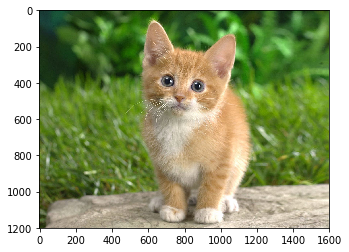

In [15]:
#viewing the test image
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
img = Image.open('cat.jpg')
plt.imshow(img)

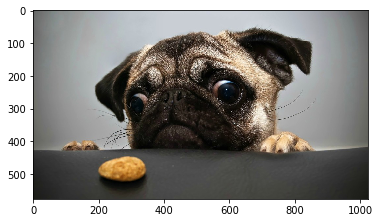

In [16]:
img = Image.open('dog.jpg')
plt.imshow(img)

In [17]:
%%time

import json

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/x-image',
    TargetModel='resnet_18.tar.gz', # this is the rest of the S3 path where the model artifacts are located
    Body=payload)

print(*json.loads(response['Body'].read()), sep = '\n')

probability=0.872028, class=n02110958 pug, pug-dog
probability=0.104198, class=n02108422 bull mastiff
probability=0.008651, class=n02108089 boxer
probability=0.006551, class=n04409515 tennis ball
probability=0.001599, class=n03942813 ping-pong ball
CPU times: user 13.3 ms, sys: 62 µs, total: 13.4 ms
Wall time: 3.38 s


When we invoke the same ResNet 18 model a 2nd time, it is already downloaded to the instance and loaded in the container, so inference is faster.

In [18]:
%%time

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/x-image',
    TargetModel='resnet_18.tar.gz',
    Body=payload)

print(*json.loads(response['Body'].read()), sep = '\n')

probability=0.872028, class=n02110958 pug, pug-dog
probability=0.104198, class=n02108422 bull mastiff
probability=0.008651, class=n02108089 boxer
probability=0.006551, class=n04409515 tennis ball
probability=0.001599, class=n03942813 ping-pong ball
CPU times: user 6.32 ms, sys: 0 ns, total: 6.32 ms
Wall time: 134 ms


### Invoke another model
Exercising the power of a multi-model endpoint, we can specify a different model (resnet_152.tar.gz) as `TargetModel` and perform inference on it using the same endpoint.

In [19]:
%%time

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/x-image',
    TargetModel='resnet_152.tar.gz',
    Body=payload)

print(*json.loads(response['Body'].read()), sep = '\n')

probability=0.979114, class=n02110958 pug, pug-dog
probability=0.003781, class=n02108422 bull mastiff
probability=0.003718, class=n02112706 Brabancon griffon
probability=0.002666, class=n04409515 tennis ball
probability=0.001355, class=n02096585 Boston bull, Boston terrier
CPU times: user 6.26 ms, sys: 158 µs, total: 6.42 ms
Wall time: 8.17 s


### Add models to the endpoint
We can add more models to the endpoint without having to update the endpoint. Below we are adding a 3rd model, `squeezenet_v1.0`. To demonstrate hosting multiple models behind the endpoint, this model is duplicated 10 times with a slightly different name in S3. In a more realistic scenario, these could be 10 new different models.

In [20]:
mx.test_utils.download(model_path+'squeezenet/squeezenet_v1.0-0000.params', None, 'data/squeezenet_v1.0')
mx.test_utils.download(model_path+'squeezenet/squeezenet_v1.0-symbol.json', None, 'data/squeezenet_v1.0')
mx.test_utils.download(model_path+'synset.txt', None, 'data/squeezenet_v1.0')

with open('data/squeezenet_v1.0/squeezenet_v1.0-shapes.json', 'w') as file:
    file.write('[{"shape": [1, 3, 224, 224], "name": "data"}]')
    
with tarfile.open('data/squeezenet_v1.0.tar.gz', 'w:gz') as tar:
    tar.add('data/squeezenet_v1.0', arcname='.')

In [21]:
file = 'data/squeezenet_v1.0.tar.gz'

for x in range(0, 10):
    s3_file_name = 'demo-subfolder/squeezenet_v1.0_{}.tar.gz'.format(x)
    key = os.path.join(prefix, s3_file_name)
    with open(file, 'rb') as file_obj:
        s3.Bucket(bucket).Object(key).upload_fileobj(file_obj)
    models.add(s3_file_name)

print('Number of models: {}'.format(len(models)))
print('Models: {}'.format(models))

Number of models: 12
Models: {'demo-subfolder/squeezenet_v1.0_1.tar.gz', 'demo-subfolder/squeezenet_v1.0_6.tar.gz', 'resnet_18.tar.gz', 'demo-subfolder/squeezenet_v1.0_7.tar.gz', 'demo-subfolder/squeezenet_v1.0_9.tar.gz', 'demo-subfolder/squeezenet_v1.0_2.tar.gz', 'demo-subfolder/squeezenet_v1.0_3.tar.gz', 'resnet_152.tar.gz', 'demo-subfolder/squeezenet_v1.0_4.tar.gz', 'demo-subfolder/squeezenet_v1.0_5.tar.gz', 'demo-subfolder/squeezenet_v1.0_8.tar.gz', 'demo-subfolder/squeezenet_v1.0_0.tar.gz'}


After uploading the SqueezeNet models to S3, we will invoke the endpoint 100 times, randomly choosing from one of the 12 models behind the S3 prefix for each invocation, and keeping a count of the label with the highest probability on each invoke response.

In [22]:
%%time

import random
from collections import defaultdict

results = defaultdict(int)

for x in range(0, 100):
    target_model = random.choice(tuple(models))
    response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/x-image',
        TargetModel=target_model,
        Body=payload)

    results[json.loads(response['Body'].read())[0]] += 1
    
print(*results.items(), sep = '\n')

('probability=0.207832, class=n03476684 hair slide', 83)
('probability=0.979114, class=n02110958 pug, pug-dog', 11)
('probability=0.872028, class=n02110958 pug, pug-dog', 6)
CPU times: user 342 ms, sys: 8.52 ms, total: 351 ms
Wall time: 49.1 s


### Updating a model
To update a model, you would follow the same approach as above and add it as a new model. For example, if you have retrained the `resnet_18.tar.gz` model and wanted to start invoking it, you would upload the updated model artifacts behind the S3 prefix with a new name such as `resnet_18_v2.tar.gz`, and then change the `TargetModel` field to invoke `resnet_18_v2.tar.gz` instead of `resnet_18.tar.gz`. You do not want to overwrite the model artifacts in Amazon S3, because the old version of the model might still be loaded in the containers or on the storage volume of the instances on the endpoint. Invocations to the new model could then invoke the old version of the model.

## (Optional) Delete the hosting resources

In [23]:
#sm_client.delete_endpoint(EndpointName=endpoint_name)
#sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
#sm_client.delete_model(ModelName=model_name)

In [24]:
print(time.time()-tic)

66.42592525482178
